# FIR Filter Acceleration of PYNQ ZCU104
We will first implement FIR filter using SciPy function lfilter and will measure its performance.After that ,we will load a custom overlay with a hardware FIR,and compare its performance to the software implementation.



In [1]:
#PLOT FUNCTION 
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_sig,n_samples,out_sig=None):
    plt.figure()
    plt.subplot(1,1,1)
    plt.xlabel('Time(usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_sig[:n_samples],'b-',label='Input signal') #n_samples argument to limit the number of samples to plot
    if out_sig is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_sig[:n_samples],'r-',linewidth=2,label='FIR output')
    plt.legend()


**Generate the noisy input signal**
The main signal is 200 kHz . We addded 46 MHz and 12 MHz sinusoids to simulate noise.

Number os samples1:  200000
Number os samples2:  400000


<IPython.core.display.Javascript object>


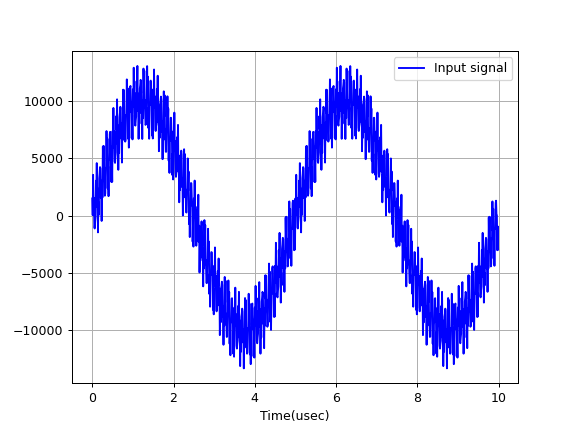

In [2]:
import numpy as np

T1=0.002 #Total time
fs1=100e6 #Sampling frequency
fs2=200e6
n1=int(T1*fs1) #Number of samples
n2=int(T1*fs2)
t1=np.linspace(0,T1,n1,endpoint=False) #Time vector in seconds
t2=np.linspace(0,T1,n2,endpoint=False)
samples1=10000*np.sin(0.2e6*2*np.pi*t1)+1500*np.cos(46e6*2*np.pi*t1)+2000*np.sin(12e6*2*np.pi*t1) #Samples of the signal
samples1=samples1.astype(np.int32) #Convert samples to 32 bit integers
samples2=10000*np.sin(0.2e6*2*np.pi*t2)+1500*np.cos(46e6*2*np.pi*t2)+2000*np.sin(12e6*2*np.pi*t2)
samples2=samples2.astype(np.int32)
print('Number os samples1: ',len(samples1))
print('Number os samples2: ',len(samples2))
plot_to_notebook(t1,samples1,1000)
# plot_to_notebook(t2,samples2,1000)


**Software FIR filter Using SciPy**
LPF with passband 0-5 MHz ,Stopband 10-50 MHz, Sampling frequency 100 MHz

Software FIR execution time:  0.12177681922912598


<IPython.core.display.Javascript object>


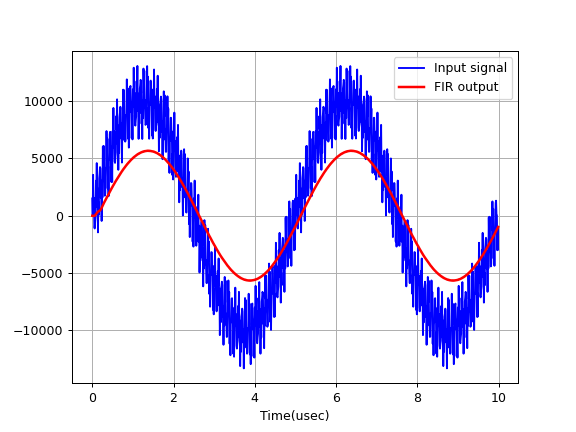

In [3]:
from scipy.signal import lfilter
coeffs=[-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

import time
start_time=time.time()
sw_fir_output1=lfilter(coeffs,70e3,samples1)
sw_fir_output2=lfilter(coeffs,70e3,samples2)
stop_time=time.time()
sw_exec_time=stop_time-start_time
print('Software FIR execution time: ',sw_exec_time)

plot_to_notebook(t1,samples1,1000,out_sig=sw_fir_output1)
# plot_to_notebook(t2,samples2,1000,out_sig=sw_fir_output2)

**Hardware FIR Implementation**
DMA will transfer the samples to FIR filter and receive what comes out of the FIR filter.It will go from memory through the filter and back into the memory

In [4]:
from pynq import Overlay
import pynq.lib.dma

handle=Overlay("FIR.bit")#Load the Overlay
dma=handle.filter.fir_dma#Load the FIR DMA

In [5]:
from pynq import allocate
import numpy as np

in_buffer=allocate(shape=(n1,),dtype=np.int32)#Allocate buffers for input signals
out_buffer=allocate(shape=(n1,),dtype=np.int32)#Allocate buffers for output signals

In [6]:
np.copyto(in_buffer,samples1)#copy the samples to in_buffer
print(in_buffer)

[ 1500    41  3561 ... -3011  -932 -2947]


In [7]:
#Trigger the DMA transfer and wait for the reasult
import time
start_time=time.time()

In [8]:
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.recvchannel.wait()

In [9]:
stop_time=time.time()
hw_exec_time=stop_time-start_time
print('HW FIR execution time: ',hw_exec_time)
print('HW acceleration factor: ',sw_exec_time/hw_exec_time)

HW FIR execution time:  0.05433297157287598
HW acceleration factor:  2.2413060744485254


<IPython.core.display.Javascript object>


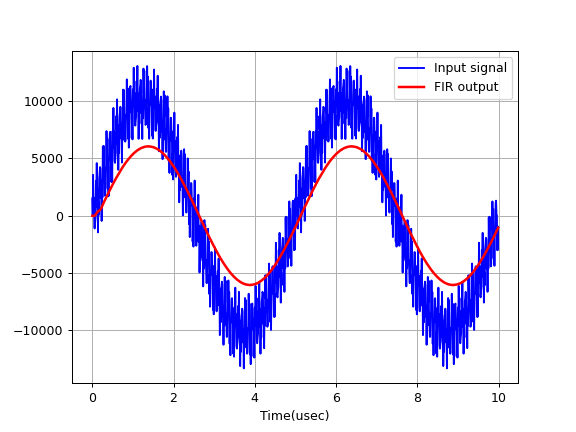

In [10]:
plot_to_notebook(t1,samples1,1000,out_sig=out_buffer)

in_buffer.close()
out_buffer.close()